# Bias-variance trade-off

This notebook consists of 4 parts:
1. A high-level summary of the bias-variance trade-off;
2. A theoretical break-down of total model error into bias, variance, and noise;
3. A practical example computation of each of these terms using polynomial regression;
4. (Maybe) Examples to reduce bias or variance (Ridge, bagging)

Sources
- https://gist.github.com/fabgoos/6788818
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- Book: Elements of Statistical Learning 

## Summary

We build a model using a specific algorithm on a given dataset. 
The bias-variance trade-off is about model error due to the algorithm vs the dataset.

The total model's error can be decomposed into variance, bias, and noise.
- **Variance** 
quantifies how much our model, built on this particular dataset,
would change if we used another dataset, with the same algorithm. 
High model variance means the model is overfitting the data.
- **Bias** 
quantifies how much a model based on the _average dataset_ 
would differ from the true label. It's about how wrong our algorithm is.
High model bias means the model is underfitting.
- **Noise** is intrinsic to the domain.
Noise appears when 2 identical data points have different labels.
Noise is measurable, but our model is independent of it.



## Theoretical breakdown

First, let's introduce a lemma: $E[x^2] = E[(x - E(x))^2] + E[x]^2$

Proof: 
$
E[(x - E[x])^2] 
\\= E[x^2 - 2xE[x] + E[x]^2] 
\\= E[x^2] - 2E[xE[x]] + E[E[x]^2]
\\= E[x^2] - E[x]^2
$

Now to the bias-variance breakdown. 
We built our model and want to predict the value of a newly-seen data point. 
We define: 
- $x$ is the feature vector of the new data point.
- $y$ is the dependent variable, given to us in the dataset.
- $\epsilon$ is the noise in the DV $y$. We assume that $\epsilon$ is normally distributed around 0.
- $z$ is the true DV of the new datapoint, without noise, such that $y = z + \epsilon$. 
- $\hat{y}$ is the prediction of our model, $h$, for $y$: $\hat{y} = h(x)$.

Let's look at the expected value, over all the possible models we could build, 
of the squared error of our prediction for this new data point. 

$
E[SE]
\\= E[(\hat{y}-y)^2]
\\= E[\hat{y}^2 - 2y\hat{y} + y^2]
\\= E[\hat{y}^2] - 2E[\hat{y}y] + E[y^2]
$

Here we apply the lemma above.

$
E[SE] 
\\= E[ (\hat{y}-E[\hat{y}])^2] + E[\hat{y}]^2 - 2E[y]E[\hat{y}] + E[(y-E[y])^2] + E[y]^2
\\= E[ (\hat{y}-E[\hat{y}])^2] + ( E[\hat{y}]-E[y])^2 + E[\epsilon^2]
\\= variance + bias^2 + noise
$

We just broke down the typical prediction error into bias, variance, and noise.
The "trade-off" part is: if you held this error and noise constant, 
decreasing bias would increase variance, and vice-versa.

# Example: polynomial regression

1. Generate and plot data: 
$z$ is the true dependent variable, 
directly generated from the `sin` function, 
$y$ is the DV + noise.
2. Build model:
Train a polynomial regression of specified degree. 
Higher degree means more overfitting.
3. Fit model to the training data.

,x_id,x,y,z
0,0,0.000000,1.624345,0.000000
1,1,0.091837,-0.337117,0.274640
2,2,0.183673,0.015904,0.544076
3,3,0.275510,-0.269765,0.803204
4,4,0.367347,1.912521,1.047114


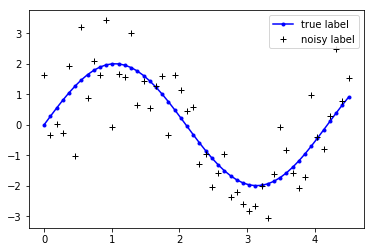

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def generate_sample(sample_size=50, seed=1):
    """ generate a df with:
    x in [0,5], 
    y (noisy label = sin(x)+epsilon), 
    z (true label = sin(x))
    """
    np.random.seed(seed)
    x = np.linspace(0, 4.5, sample_size)
    z = 2 * np.sin(x * 1.5)
    noise = np.random.normal(0, 1, sample_size)
    y = z + noise
    df = pd.DataFrame({'x':x, 'y':y, 'z':z})
    df.index.name = 'x_id' # need index to later join other samples
    return df.reset_index()

def plot_xyz(df):
    """ plot true label and noisy label. """
    plt.plot(df['x'], df['z'], 'b.-')
    plt.plot(df['x'], df['y'], 'k+') 
    plt.legend(['true label','noisy label'])

df = generate_sample()
plot_xyz(df)
df.head()

model:-0.27x^0 + 5.15x^1 + -3.65x^2 + 0.58x^3


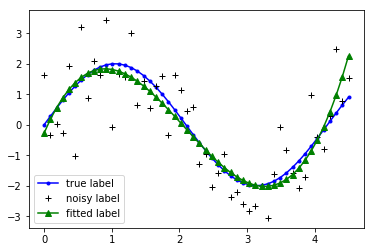

In [2]:
# train and test polynomial regression model

from sklearn.linear_model import LinearRegression
        
def train_poly_linreg(x, y, degree):
    """ Fit a polynomial to the train set x and label y. """
    model = LinearRegression(fit_intercept=False)
    # vander([1,2],3,True) = [[1^0,1^1,1^2],[2^0,2^1,2^2]]
    model.fit(np.vander(x, degree + 1, increasing=True), y)
    return model

def test_poly_linreg(model, x):
    """ Apply polynomial model to test set x. 
    Output predicted values for inputs x.
    model must be a LinearRegression
    """
    degree = model.coef_.size - 1
    y = model.predict(np.vander(x, degree + 1, increasing=True))
    return y

def train_test_poly_linreg(df, degree, verbose=False):
    """ train and test a polynomial model """
    model = train_poly_linreg(df['x'], df['y'], degree)
    if verbose:
        model_str = ' + '.join(
            ['{:0.2f}x^{}'.format(c,i) 
             for i,c in enumerate(model.coef_)]
        )
        print('model:' + model_str)
    df['yp'] = test_poly_linreg(model, df['x'])
    return df

def plot_xyz_preds(df):
    """ plot true label, noisy label, and predicted label.
    df must have columns: x, y, z, y_pred """
    plt.plot(df['x'], df['z'], 'b.-')
    plt.plot(df['x'], df['y'], 'k+') 
    plt.plot(df['x'], df['yp'], 'g^-')
    plt.legend(['true label','noisy label','fitted label'])
    
plot_xyz_preds(
    train_test_poly_linreg(
        generate_sample(), 
        degree=3,
        verbose=True
    )
)


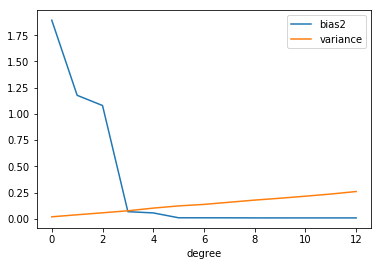

In [3]:
def generate_samples(sample_size=50, degree=3, n_samples=100):
    """ Produce df mapping (sample_id, x_id) to (x, y, z, yp) 
    Output df has sample_size * n_samples rows.
    """
    df = pd.concat([
        (
            train_test_poly_linreg(
                generate_sample(sample_size, seed=i), 
                degree
            )
            .assign(sample_id=i)
        )
        for i in range(n_samples)
    ]).reset_index(drop=True)
    return df


def compute_bias2_variance(df):
    """ Given a df mapping (sample_id, x_id) to (x, y, z, yp),
    return bias2 and variance, both averaged over all x_id.
    I'm not sure why fabgoos is taking norm and not mean.
    https://gist.github.com/fabgoos/6788818

    """
    # for each x, compute bias2 = ( E[yp]-E[y] )^2
    # note that E[y] = z, but we are never given z in practice.
    bias_df = (
        df
        .groupby('x_id')
        .agg({'yp':'mean', 'y':'mean'})
        .assign(bias2=lambda r: (r['yp']-r['y'])**2)
        [['bias2']]
    )
    # for each x, compute yp variance = E[ (yp-E[yp])^2 ]
    variance_df = (
        df
        .groupby('x_id')
        .agg({'yp':'var'})
        .rename({'yp':'var'}, axis=1)
    )
    # join the two and average
    def norm(series): # L2 norm, ie sqrt(sum(squares))
        return np.linalg.norm(list(series)) # could use series.values too

    bias2, var = (
        pd.concat([bias_df, variance_df], axis=1)
        .agg(['mean','mad',norm])
        .loc['mean'] # keep only mean for now
    )

    return bias2, var


def generate_and_plot_bias2_variance_over_degrees(max_degree=12):
    """ """
    rows = [
        [d] + list(compute_bias2_variance(generate_samples(degree=d)))
        for d in range(max_degree+1)
    ]
    df = (
        pd.DataFrame(rows, columns=['degree','bias2','variance'])
        .set_index('degree')
    )
    df.plot()
    
generate_and_plot_bias2_variance_over_degrees()